# Potts model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import igraph as ig
import pandas as pd

In [2]:
N = 500
J = 1
H = 0

In [3]:
def calcEnergy(node_orientations, edge_df):
    """
    INPUT
    -----
    node_orientations: np array of node orientations
    edge_df: pandas dataframe containing edge information

    RETURN
    ------
    Energy of the network for the given configuration
    """

    # Only have nodes with the same orientation contribute to energy (what is done in paper, different from course!)
    E_int = 0

    for i, _ in enumerate(edge_df.index):
        source = edge_df["source"].iloc[i]
        target = edge_df["target"].iloc[i]
        if node_orientations[source] == node_orientations[target]:
            E_int += 1
    
    E_self = node_orientations[node_orientations == 1]
    return J*E_int + np.sum(H*E_self)

In [5]:
def MC_step(graph, p, temp):
    """
    Monte Carlo step
    """
    beta = 1/temp

    randNode_index = np.random.randint(graph.vcount())
    newSpin = np.random.randint(1, p+1)
    oldSpin = graph.vs[randNode_index]["q"]
    if oldSpin == newSpin:
        return graph
    
    oldE = calcEnergy(graph.vs["q"], graph.get_edge_dataframe())

    # Flip spin
    graph.vs[randNode_index]["q"] = newSpin
    newE = calcEnergy(graph.vs["q"], graph.get_edge_dataframe())

    deltaE = newE - oldE
    if deltaE > 0:
        accProb = np.exp(-beta*deltaE)
        r = np.random.uniform()
        if r > accProb:
            graph.vs[randNode_index]["q"] = oldSpin
    
    return graph

def calcMagnetisation(orientations, p):
    M_vals = np.zeros(p)
    for q in orientations:
        M_vals[q-1] += 1
    
    return M_vals

In [7]:
def runMCsim(p, gamma, temp, N_steps=2000, iterations=100, display_progress=False):
    E_evol = np.zeros(N_steps)
    M_evol = np.zeros((iterations, N_steps, p))

    for i in range(iterations):
        print(f"Running iteration {i+1}/{iterations}")
        g = ig.Graph.Static_Power_Law(N, N, gamma)
        g.vs["q"] = np.random.randint(1, p+1, size=N)
        
        for j in range(N_steps):
            if display_progress:
                print(f"{np.round(j*100/N_steps, 0)}%", end="\r")
            g = MC_step(g, p, temp)
            orientations = g.vs["q"]
            E_evol[j] += calcEnergy(orientations, g.get_edge_dataframe())
            M_evol[i][j] += calcMagnetisation(orientations, p)

    E_evol /= iterations

    return E_evol, M_evol, g

def calc_Tc(g, p):
    degrees = np.array(g.degree())
    av_deg = np.sum(degrees)/len(degrees)
    second_mom = np.sum(degrees**2)/len(degrees)

    inverse = np.log((second_mom + (p-2)*av_deg)/(second_mom - 2*av_deg))
    return 1/inverse

In [9]:
steps = 8000
gamma = 3
p = 3
iterations = 2

g = ig.Graph.Static_Power_Law(N, N, gamma)
Tc = calc_Tc(g, p)
T_vals = np.linspace(0.2*Tc, 3.01*Tc, 20)
E_evols = np.zeros((len(T_vals), steps))
M_evols = np.zeros((len(T_vals), iterations, steps, p))

for i, temp in enumerate(T_vals):
    print(f"Running for T = {temp}")
    E_evol, M_evol, g = runMCsim(p, gamma, temp, steps, iterations)
    E_evols[i] += E_evol
    M_evols[i] += M_evol

Running for T = 0.2208419557064233
Running iteration 1/2
Running iteration 2/2
Running for T = 0.38414877032090994
Running iteration 1/2
Running iteration 2/2
Running for T = 0.5474555849353966
Running iteration 1/2
Running iteration 2/2
Running for T = 0.7107623995498833
Running iteration 1/2
Running iteration 2/2
Running for T = 0.8740692141643699
Running iteration 1/2
Running iteration 2/2
Running for T = 1.0373760287788567
Running iteration 1/2
Running iteration 2/2
Running for T = 1.2006828433933432
Running iteration 1/2
Running iteration 2/2
Running for T = 1.3639896580078297
Running iteration 1/2
Running iteration 2/2
Running for T = 1.5272964726223166
Running iteration 1/2
Running iteration 2/2
Running for T = 1.690603287236803
Running iteration 1/2
Running iteration 2/2
Running for T = 1.85391010185129
Running iteration 1/2
Running iteration 2/2
Running for T = 2.0172169164657765
Running iteration 1/2
Running iteration 2/2
Running for T = 2.180523731080263
Running iteration 1/

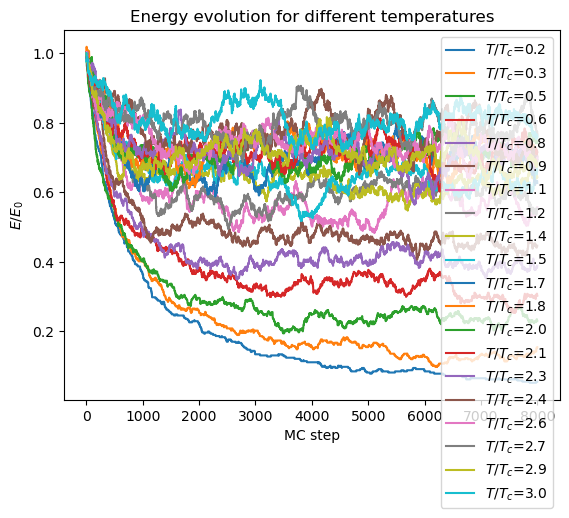

In [13]:
for i, E_evol in enumerate(E_evols):
    plt.plot(np.arange(steps), E_evol/E_evol[0], label=r"$T/T_c$" + f"={np.round(T_vals[i]/Tc, 1)}")
    plt.legend()
plt.title("Energy evolution for different temperatures")
plt.xlabel("MC step")
plt.ylabel(r"$E/E_0$")
plt.show()

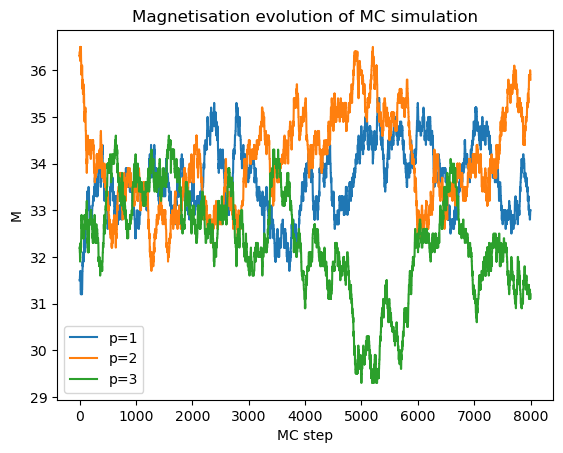

In [14]:
for i, M_series in enumerate(np.sum(M_evols[0], axis=0).T/10):
    plt.plot(np.arange(steps), M_series, label=f"p={i+1}")
plt.title("Magnetisation evolution of MC simulation")
plt.xlabel("MC step")
plt.ylabel("M")
plt.legend()
plt.show()

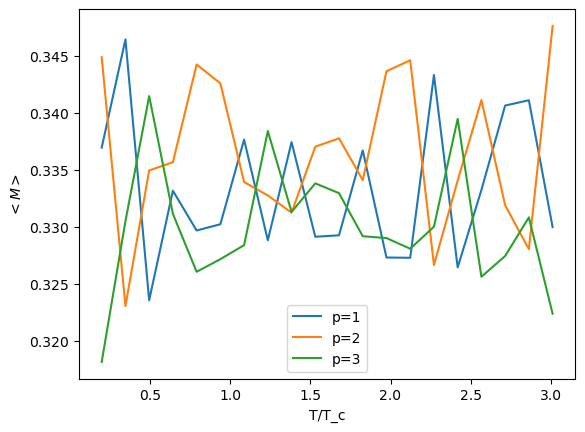

In [16]:
selection = M_evols[:, :, 3000:, :]
av = selection.mean(axis=(1,2))
for i, p_series in enumerate(av.T/N):
    plt.plot(T_vals/Tc, p_series, label=f"p={i+1}")
    plt.legend()

plt.xlabel(r"T/T_c")
plt.ylabel(r"$<M>$")
plt.show()